In [1]:
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [16]:
len(list(image_datasets['train']))

244

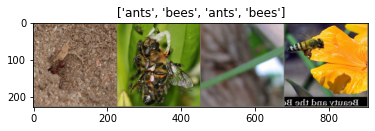

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5814 Acc: 0.7008
val Loss: 0.5310 Acc: 0.7582

Epoch 1/24
----------
train Loss: 0.8661 Acc: 0.7049
val Loss: 0.5777 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.5623 Acc: 0.7992
val Loss: 0.3511 Acc: 0.8431

Epoch 3/24
----------
train Loss: 0.6688 Acc: 0.7377
val Loss: 0.3406 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.5696 Acc: 0.7787
val Loss: 0.8197 Acc: 0.7712

Epoch 5/24
----------
train Loss: 0.8385 Acc: 0.7541
val Loss: 0.4490 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.4304 Acc: 0.8525
val Loss: 0.3693 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4679 Acc: 0.8443
val Loss: 0.2915 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3028 Acc: 0.8648
val Loss: 0.2695 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3519 Acc: 0.8361
val Loss: 0.2473 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2272 Acc: 0.9016
val Loss: 0.2443 Acc: 0.8954

Epoch 11/24
----------
train Loss: 0.4295 Acc: 0.7869
val Loss: 0.2508 Acc: 0.9085

Ep

In [137]:
model_ft.state_dict()
torch.save(model_ft.state_dict(), './RESNET_SIMPLE_STATE_DICT')

In [138]:
from torchvision import transforms as T
from torchvision import models
import torch

# JIT-able model
class InferenceModel(nn.Module):
    def __init__(self, RESNET_STATE_DICT_PATH:str):
        super().__init__()
        self.tfs = nn.Sequential(
            T.Resize([256,]),
            T.CenterCrop(224),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        )
        self.model_resnet = models.resnet18().eval()
        self.model_resnet.fc = nn.Linear(self.model_resnet.fc.in_features, 2).eval()
        self.model_resnet.load_state_dict(torch.load(RESNET_STATE_DICT_PATH))
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.tfs(x)
        outputs = self.model_resnet(x)
        return outputs
            

In [139]:
model = InferenceModel('RESNET_SIMPLE_STATE_DICT').eval()

In [140]:
from PIL import Image
img = Image.open("hymenoptera_data/val/ants/desert_ant.jpg")
ip = T.ToTensor()(img)[None,:]
ip

tensor([[[[0.6353, 0.5373, 0.5098,  ..., 0.5216, 0.5569, 0.5529],
          [0.5804, 0.5294, 0.5333,  ..., 0.4627, 0.5255, 0.5412],
          [0.6118, 0.5843, 0.5804,  ..., 0.5020, 0.5412, 0.5451],
          ...,
          [0.6588, 0.5882, 0.6000,  ..., 0.7529, 0.7294, 0.6706],
          [0.6510, 0.6706, 0.7020,  ..., 0.7137, 0.7020, 0.6941],
          [0.6118, 0.6392, 0.6745,  ..., 0.7059, 0.6784, 0.6510]],

         [[0.4745, 0.3765, 0.3529,  ..., 0.4000, 0.4353, 0.4314],
          [0.4157, 0.3647, 0.3725,  ..., 0.3412, 0.4039, 0.4196],
          [0.4392, 0.4118, 0.4157,  ..., 0.3725, 0.4118, 0.4157],
          ...,
          [0.4784, 0.4078, 0.4196,  ..., 0.5098, 0.4902, 0.4431],
          [0.4706, 0.4980, 0.5294,  ..., 0.4980, 0.4941, 0.4784],
          [0.4314, 0.4667, 0.5020,  ..., 0.4902, 0.4706, 0.4353]],

         [[0.2627, 0.1647, 0.1490,  ..., 0.2196, 0.2549, 0.2510],
          [0.2275, 0.1765, 0.1922,  ..., 0.1608, 0.2235, 0.2392],
          [0.2863, 0.2588, 0.2667,  ..., 0

In [141]:
def time_inference_without_jit():
    return model.forward(ip)
with torch.inference_mode():
    op = time_inference_without_jit()
    print(op)

tensor([[ 4.4004, -5.8460]])


In [142]:
scripted_model = torch.jit.script(model).to(device).eval()

In [146]:
scripted_model.save('INFERENCE_MODEL')

In [17]:
scripted_model = torch.jit.load('INFERENCE_MODEL')

In [143]:
def time_inference_with_jit():
    return scripted_model.forward(ip)

In [144]:
with torch.inference_mode():
    op = time_inference_with_jit()
print(op)

tensor([[ 4.4004, -5.8460]])


In [112]:
# NOTE: running top in bash shows that there is always 95-100% CPU usage in these timeit ops.
# since this is highly CPU bound, we can easily find how many requests we can serve per second per CPU core
# in case this sucks, we will have to try GPU

In [111]:
%timeit -n 30 time_inference_without_jit()

99.4 ms ± 848 µs per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [113]:
%timeit -n 30 time_inference_with_jit()

98.9 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 30 loops each)


In [114]:
m1 = models.resnet18(pretrained=True)

In [115]:
sm1 = torch.jit.script(m1)

In [116]:
m1 = m1.to(device).eval()
sm1 = m1.to(device).eval()

In [119]:
%timeit -n 10 sm1.forward(ip)

1.01 s ± 10 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [120]:
%timeit -n 10 m1.forward(ip)

1e+03 ms ± 4.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [123]:
%timeit -n 10 model_ft.forward(ip)

1.01 s ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [130]:
smodel_ft = torch.jit.script(model_ft, optimize=True)

In [131]:
%%timeit -n 3 
# with torch.optimized_execution():
smodel_ft.forward(ip)

1.01 s ± 23.2 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [24]:
model_ft.load_state_dict(torch.load('RESNET_SIMPLE_STATE_DICT'))

<All keys matched successfully>

In [28]:
scripted_model = model_ft

In [30]:
import torch_pruning as tp
scripted_model.eval()

# 1. setup strategy (L1 Norm)
strategy = tp.strategy.L1Strategy() # or tp.strategy.RandomStrategy()

# 2. build layer dependency for resnet18
DG = tp.DependencyGraph()
DG.build_dependency(scripted_model, example_inputs=torch.randn(1,3,224,224))

# 3. get a pruning plan from the dependency graph.
pruning_idxs = strategy(scripted_model.conv1.weight, amount=0.4) # or manually selected pruning_idxs=[2, 6, 9, ...]
pruning_plan = DG.get_pruning_plan( scripted_model.conv1, tp.prune_conv, idxs=pruning_idxs )
print(pruning_plan)

# 4. execute this plan (prune the model)
# pruning_plan.exec()


-------------
[ <DEP: prune_conv => prune_conv on conv1 (Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False))>, Index=[2, 3, 4, 7, 9, 12, 13, 16, 17, 18, 21, 29, 32, 34, 35, 36, 37, 38, 45, 46, 48, 54, 58, 61, 62], NumPruned=3675]
[ <DEP: prune_conv => prune_batchnorm on bn1 (BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))>, Index=[2, 3, 4, 7, 9, 12, 13, 16, 17, 18, 21, 29, 32, 34, 35, 36, 37, 38, 45, 46, 48, 54, 58, 61, 62], NumPruned=50]
[ <DEP: prune_batchnorm => _prune_elementwise_op on _ElementWiseOp()>, Index=[2, 3, 4, 7, 9, 12, 13, 16, 17, 18, 21, 29, 32, 34, 35, 36, 37, 38, 45, 46, 48, 54, 58, 61, 62], NumPruned=0]
[ <DEP: _prune_elementwise_op => _prune_elementwise_op on _ElementWiseOp()>, Index=[2, 3, 4, 7, 9, 12, 13, 16, 17, 18, 21, 29, 32, 34, 35, 36, 37, 38, 45, 46, 48, 54, 58, 61, 62], NumPruned=0]
[ <DEP: _prune_elementwise_op => prune_related_conv on layer1.0.conv1 (Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

In [41]:
def loss(model):
    running_loss = 0.0
    running_corrects = 0
    criterion = nn.CrossEntropyLoss()

    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val']

    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

In [42]:
loss(scripted_model)

Loss: 0.2312 Acc: 0.9281


In [43]:
pruning_plan.exec()

93425

In [45]:
# automatic pruning not working lol

In [44]:
loss(scripted_model)

Loss: 0.6170 Acc: 0.7386
